In [1]:
import copy, math
import torch
import torch.nn as nn
from utils.display import *

#### Visualise the increase in sparisty during training

In [2]:
def z(t, Z, t_0, S) : return Z * (1 - (1 - (t - t_0) / S)**3)

In [3]:
t_0 = 1000 # Step to start pruning
Z = 0.98 # Target sparsity 
S = 200_000 # Num pruning steps

In [4]:
sparsity = []
for t in range(t_0, S + t_0 * 2, 1000) :
    z_t = z(t, Z, t_0, S)
    sparsity += [z_t]

0.98

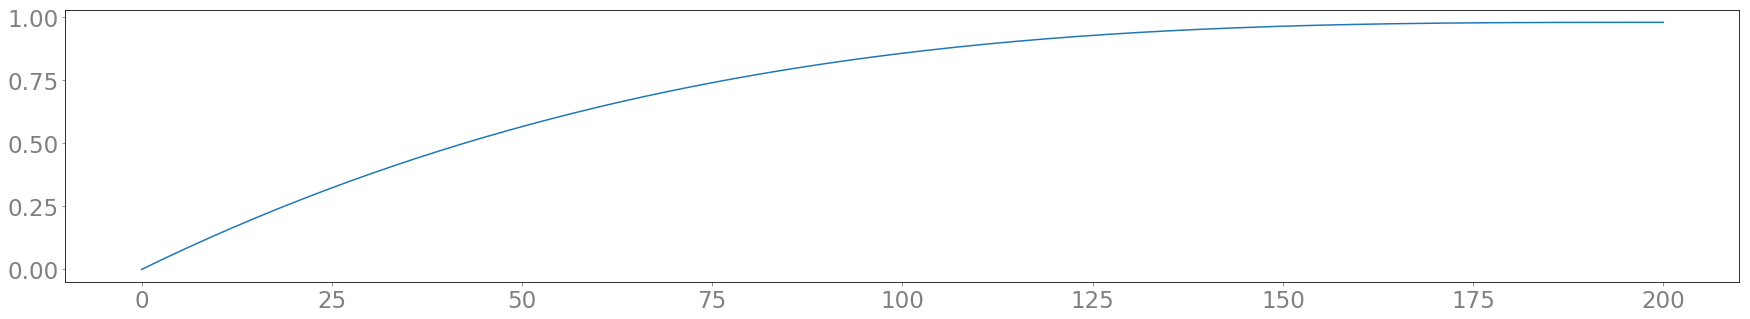

In [5]:
plot(sparsity)
sparsity[-1]

#### Pick some sparsity at time t and create mask from it

In [6]:
# target sparsity @ t
z_t = 0.75 

In [7]:
# Our weight matrx
size = (4, 4)
num_params = size[0] * size[1]
W = torch.randn(size) 
W 

tensor([[-1.2463,  0.7599, -0.4133, -2.3861],
        [ 0.9806,  0.4379, -0.4202, -1.6814],
        [-0.3063,  0.4543, -0.3774,  1.8272],
        [ 1.5259,  2.8422, -0.8745, -0.2656]])

In [8]:
# Sort the magnitudes
W_abs = torch.abs(W)
sorted_abs, _ = torch.sort(W_abs.view(-1))
sorted_abs

tensor([0.2656, 0.3063, 0.3774, 0.4133, 0.4202, 0.4379, 0.4543, 0.7599, 0.8745,
        0.9806, 1.2463, 1.5259, 1.6814, 1.8272, 2.3861, 2.8422])

In [9]:
# Pick the threshold 
target_idx = int(num_params * z_t) - 1
threshold = sorted_abs[target_idx]
threshold

tensor(1.5259)

In [10]:
# And...BAM we have a mask!
mask = (W_abs > threshold).float()
mask

tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])

In [11]:
# Prune weights
W * mask 

tensor([[-0.0000,  0.0000, -0.0000, -2.3861],
        [ 0.0000,  0.0000, -0.0000, -1.6814],
        [-0.0000,  0.0000, -0.0000,  1.8272],
        [ 0.0000,  2.8422, -0.0000, -0.0000]])

In [12]:
# double-check sparsity is ok
z_t, 1 - mask.sum() / num_params

(0.75, tensor(0.7500))

#### Refactor into functions

In [27]:
def np_now(tensor) : return tensor.detach().cpu().numpy()

In [28]:
def clamp(x, lo=0, hi=1) : return max(lo, min(hi, x))

In [29]:
class PruneMask(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.mask = None
        self.num_params = None

    def mask_from_matrix(self, W, z) :    
        # Sort the magnitudes
        W_abs = torch.abs(W)
        sorted_abs, _ = torch.sort(W_abs.view(-1))

        # Pick the threshold 
        target_idx = int(W.size(0) * W.size(1) * z) - 1
        threshold = sorted_abs[target_idx]

        # Create the mask
        return (W_abs > threshold).float()        

In [16]:
class DenseMask(PruneMask) :
    def __init__(self, layer) :
        super().__init__()
        self.init_mask(layer)
    
    def init_mask(self, layer) :
        size = layer.weight.size()
        self.mask = nn.Parameter(torch.ones(size), requires_grad=False)
        self.num_params = size[0] * size[1]
    
    def update_mask(self, layer, z) :
        self.mask.data = self.mask_from_matrix(layer.weight.data, z)
                        
    def apply_mask(self, layer) :
        layer.weight.data = layer.weight.data * self.mask    

In [17]:
class GRUMask(PruneMask) :    
    def __init__(self, layer) :
        super().__init__()
        self.init_mask(layer)
    
    def init_mask(self, layer) :    
        size = layer.weight_hh_l0.size()
        self.mask = nn.Parameter(torch.ones(size), requires_grad=False)
        self.num_params = size[0] * size[1]
        
    def mask_from_gru(self, G, z) :
        # Split up the fused matrix
        n = G.size(0) // 3
        gates = [G[i*n:(i+1)*n] for i in range(3)]

        # Prune each gate
        gate_masks = []
        for W in gates : 
            gate_masks += [self.mask_from_matrix(W, z)]
        return torch.cat(gate_masks)
    
    def update_mask(self, layer, z) :
        self.mask.data = self.mask_from_gru(layer.weight_hh_l0.data, z)
        
    def apply_mask(self, layer) :
        layer.weight_hh_l0.data = layer.weight_hh_l0.data * self.mask

In [21]:
class Pruner(nn.Module) :
    def __init__(self, layers, start_step, n_steps, 
                 target_sparsity, plastic=False) :
        super().__init__()
        self.z = 0
        self.t_0 = start_step
        self.S = n_steps
        self.Z = target_sparsity
        self.plastic = plastic
        self.masks = []
        for layer in layers : 
            self.masks += [self.get_mask(layer)]
        
    def update_sparsity(self, t) :
        z = self.Z * (1 - (1 - (t - self.t_0) / self.S)**3)
        self.z = clamp(z, 0, self.Z)
    
    def forward(self, layers, t) :
        self.update_sparsity(t)
        for (l, m) in zip(layers, self.masks) :
            m.update_mask(l, self.z)
            m.apply_mask(l)
    
    def get_mask(self, layer) :
        layer_type = str(layer).split('(')[0]
        print(layer_type )
        if layer_type == 'GRU' :
            mask = GRUMask(layer)
        elif layer_type == 'Linear' :
            mask = DenseMask(layer)
        return mask

In [22]:
class Model(nn.Module) :
    def __init__(self) :
        super().__init__()
        dc = copy.deepcopy
        self.rnn = nn.GRU(2, 2)
        self.fc = nn.Linear(2, 2)
        self.layers2prune = [self.rnn, self.fc]
        self.pruner = Pruner(self.layers2prune, 1000, 200_000, 0.98)
        self.t = nn.Parameter(torch.zeros(1), requires_grad=False)
        
    def forward(self, x) :
        h = torch.ones(1, 2)
        x = self.rnn(x, h)
        x = self.fc(x)
        
        self.prune()
        self.step()
        
        return x
    
    def step(self) :
        self.t += 1
    
    def prune(self) :
        t = np_now(self.t)[0]
        self.pruner(self.layers2prune, t)


In [23]:
model = Model()
model.t += 50_000
model.state_dict()

GRU
Linear


OrderedDict([('t', tensor([50000.])),
             ('rnn.weight_ih_l0', tensor([[ 0.0987, -0.5551],
                      [ 0.1191,  0.7050],
                      [-0.0226, -0.2884],
                      [ 0.4294, -0.6216],
                      [ 0.1763,  0.5504],
                      [ 0.0542,  0.3842]])),
             ('rnn.weight_hh_l0', tensor([[-0.6126,  0.5330],
                      [ 0.3324, -0.1548],
                      [-0.1299,  0.0635],
                      [ 0.4222, -0.1023],
                      [ 0.3096, -0.5720],
                      [ 0.5961,  0.3149]])),
             ('rnn.bias_ih_l0',
              tensor([ 0.6017, -0.5281, -0.6514,  0.6691,  0.0932,  0.2547])),
             ('rnn.bias_hh_l0',
              tensor([ 0.3714, -0.1580, -0.3394, -0.4609,  0.3081, -0.1764])),
             ('fc.weight', tensor([[-0.5558, -0.1578],
                      [-0.2857, -0.4465]])),
             ('fc.bias', tensor([-0.6745,  0.2735]))])

In [24]:
model.prune()
model.pruner.z

0.5582385025

In [25]:
model.state_dict()

OrderedDict([('t', tensor([50000.])),
             ('rnn.weight_ih_l0', tensor([[ 0.0987, -0.5551],
                      [ 0.1191,  0.7050],
                      [-0.0226, -0.2884],
                      [ 0.4294, -0.6216],
                      [ 0.1763,  0.5504],
                      [ 0.0542,  0.3842]])),
             ('rnn.weight_hh_l0', tensor([[-0.6126,  0.5330],
                      [ 0.0000, -0.0000],
                      [-0.1299,  0.0000],
                      [ 0.4222, -0.0000],
                      [ 0.0000, -0.5720],
                      [ 0.5961,  0.0000]])),
             ('rnn.bias_ih_l0',
              tensor([ 0.6017, -0.5281, -0.6514,  0.6691,  0.0932,  0.2547])),
             ('rnn.bias_hh_l0',
              tensor([ 0.3714, -0.1580, -0.3394, -0.4609,  0.3081, -0.1764])),
             ('fc.weight', tensor([[-0.5558, -0.0000],
                      [-0.0000, -0.4465]])),
             ('fc.bias', tensor([-0.6745,  0.2735]))])

In [26]:
model.pruner.state_dict()

OrderedDict()

In [46]:
def np_now(tensor) : return tensor.detach().cpu().numpy()

In [47]:
def clamp(x, lo=0, hi=1) : return max(lo, min(hi, x))

In [56]:
class PruneMask() :
    def __init__(self) :
        self.mask = None
        self.num_params = None

    def mask_from_matrix(self, W, z) :    
        # Sort the magnitudes
        W_abs = torch.abs(W)
        sorted_abs, _ = torch.sort(W_abs.view(-1))

        # Pick the threshold 
        target_idx = int(W.size(0) * W.size(1) * z) - 1
        threshold = sorted_abs[target_idx]

        # Create the mask
        return (W_abs > threshold).float()        

In [57]:
class DenseMask(PruneMask) :
    def __init__(self, layer) :
        self.init_mask(layer)
    
    def init_mask(self, layer) :
        size = layer.weight.size()
        self.mask = torch.ones(size)
        self.num_params = size[0] * size[1]
    
    def update_mask(self, layer, z) :
        self.mask.data = self.mask_from_matrix(layer.weight.data, z)
                        
    def apply_mask(self, layer) :
        layer.weight.data = layer.weight.data * self.mask    

In [58]:
class GRUMask(PruneMask) :    
    def __init__(self, layer) :
        self.init_mask(layer)
    
    def init_mask(self, layer) :    
        size = layer.weight_hh_l0.size()
        self.mask = torch.ones(size)
        self.num_params = size[0] * size[1]
        
    def mask_from_gru(self, G, z) :
        # Split up the fused matrix
        n = G.size(0) // 3
        gates = [G[i*n:(i+1)*n] for i in range(3)]

        # Prune each gate
        gate_masks = []
        for W in gates : 
            gate_masks += [self.mask_from_matrix(W, z)]
        return torch.cat(gate_masks)
    
    def update_mask(self, layer, z) :
        self.mask = self.mask_from_gru(layer.weight_hh_l0.data, z)
        
    def apply_mask(self, layer) :
        layer.weight_hh_l0.data = layer.weight_hh_l0.data * self.mask

In [59]:
class Pruner() :
    def __init__(self, layers, start_step, n_steps, 
                 target_sparsity, plastic=False) :
        self.z = 0
        self.t_0 = start_step
        self.S = n_steps
        self.Z = target_sparsity
        self.plastic = plastic
        self.masks = []
        for layer in layers : 
            self.masks += [self.get_mask(layer)]
        
    def update_sparsity(self, t) :
        z = self.Z * (1 - (1 - (t - self.t_0) / self.S)**3)
        self.z = clamp(z, 0, self.Z)
    
    def prune(self, layers, t) :
        self.update_sparsity(t)
        for (l, m) in zip(layers, self.masks) :
            m.update_mask(l, self.z)
            m.apply_mask(l)
    
    def get_mask(self, layer) :
        layer_type = str(layer).split('(')[0]
        print(layer_type )
        if layer_type == 'GRU' :
            mask = GRUMask(layer)
        elif layer_type == 'Linear' :
            mask = DenseMask(layer)
        return mask

In [60]:
class Model(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.rnn = nn.GRU(2, 2)
        self.fc = nn.Linear(2, 2)
        self.layers2prune = [self.rnn, self.fc]
        self.pruner = Pruner(self.layers2prune, 1000, 200_000, 0.98)
        self.t = nn.Parameter(torch.zeros(1), requires_grad=False)
        
    def forward(self, x) :
        h = torch.ones(1, 2)
        x = self.rnn(x, h)
        x = self.fc(x)
        
        self.prune()
        self.step()
        
        return x
    
    def step(self) :
        self.t += 1
    
    def prune(self) :
        t = np_now(self.t)[0]
        self.pruner.prune(self.layers2prune, t)


In [75]:
model = Model()
model.t += 44_000
model.state_dict()

GRU
Linear


OrderedDict([('t', tensor([44000.])),
             ('rnn.weight_ih_l0', tensor([[ 0.4188,  0.2847],
                      [ 0.6929, -0.6133],
                      [ 0.4902,  0.1933],
                      [-0.0470,  0.4120],
                      [-0.5915, -0.4859],
                      [ 0.4435,  0.2212]])),
             ('rnn.weight_hh_l0', tensor([[ 0.3118, -0.0459],
                      [ 0.3204, -0.6600],
                      [-0.0631, -0.4160],
                      [-0.5841, -0.5951],
                      [-0.2272,  0.1272],
                      [ 0.6513, -0.5933]])),
             ('rnn.bias_ih_l0',
              tensor([ 0.5485, -0.6841,  0.4313, -0.7063,  0.4911, -0.6876])),
             ('rnn.bias_hh_l0',
              tensor([-0.1492, -0.3885,  0.2702, -0.0892, -0.2342, -0.2213])),
             ('fc.weight', tensor([[-0.4756, -0.6594],
                      [ 0.3927, -0.0028]])),
             ('fc.bias', tensor([0.6800, 0.4384]))])

In [76]:
model.prune()
model.pruner.z

0.5059381075

In [77]:
model.state_dict()

OrderedDict([('t', tensor([44000.])),
             ('rnn.weight_ih_l0', tensor([[ 0.4188,  0.2847],
                      [ 0.6929, -0.6133],
                      [ 0.4902,  0.1933],
                      [-0.0470,  0.4120],
                      [-0.5915, -0.4859],
                      [ 0.4435,  0.2212]])),
             ('rnn.weight_hh_l0', tensor([[ 0.0000, -0.0000],
                      [ 0.3204, -0.6600],
                      [-0.0000, -0.0000],
                      [-0.5841, -0.5951],
                      [-0.0000,  0.0000],
                      [ 0.6513, -0.5933]])),
             ('rnn.bias_ih_l0',
              tensor([ 0.5485, -0.6841,  0.4313, -0.7063,  0.4911, -0.6876])),
             ('rnn.bias_hh_l0',
              tensor([-0.1492, -0.3885,  0.2702, -0.0892, -0.2342, -0.2213])),
             ('fc.weight', tensor([[-0.4756, -0.6594],
                      [ 0.0000, -0.0000]])),
             ('fc.bias', tensor([0.6800, 0.4384]))])